In [103]:
import numpy as np
import scipy as sp
import scipy.integrate as sp_int
import matplotlib.pyplot as plt
import matplotlib

In [104]:
# Set up the constants
C_m  = 1 # membrane capacitance (uF/cm^2)
g_Na = 112.5 # maximum conductances (mS/cm^2)
g_K  = 225
g_l  = 0.25
g_d  = 0.39
theta_m = -22   # half-maximum, a parameter in the original paper
                # NB: theta_m is not given by parameters from supplemental information in paper
E_Na = 50 # reversal potentials (mV)
E_K  = -90
E_l  = -70

In [105]:
# equations governing opening/closing rates.
def m_inf(V): return (1 + np.exp(-(V - theta_m)/11.5))**(-1)
def h_inf(V): return (1 + np.exp((V + 58.3)/6.7))
def tau_h(V): return 0.5 + 14*((1 + np.exp((V + 60)/12))**(-1))
def n_inf(V): return (1 + np.exp(-(V + 12.4)/6.8))**(-1)
def tau_n(V): return ((0.087 + 11.4 * ((1 + np.exp(V + 14.6)/8.6)**(-1))) *
        (0.087 + 11.4 * ((1 + np.exp(-(V - 1.3)/18.7))**(-1))))
def a_inf(V): return (1 + np.exp(-(V + 50)/20))**(-1)
def b_inf(V): return (1 + np.exp((V + 70)/6))**(-1)
tau_a = 2
tau_b = 150

In [106]:
# define the currents of the model
def I_K(V, n): return g_K * (n**2) * (V - E_K)
def I_Na(V, h): return (m_inf(V)**3) * h * (V - E_Na)
def I_d(V, a, b): return g_d * (a**3) * b * (V - E_K)
def I_l(V): return g_l * (V - E_l)

In [107]:
# define function that is time derivative of voltage: f = dV/dt
def f(t, y):
    # set external current: make sure it is 0 for large times.
    if 0 < t <= 10:
        I_e = 3
    else:
        I_e = 0
    # set noise current in input
    D = 0
    I_noise = np.sqrt(2*D*np.random.normal(0, 1))
    # set the variables that are to be integrated
    V, n, h, a, b = y

    # define DV/dt ('_dot' denotes time differentiation)
    V_dot = 1/C_m * (I_e + I_noise - (I_K(V, n) + I_Na(V, h) + I_d(V, a, b) + I_l(V)))

    # enter the equations controlling the gating variables.
    n_dot = (n_inf(V) - n) / tau_n(V)
    h_dot = (h_inf(V) - h) / tau_h(V)
    a_dot = (a_inf(V) - a) / tau_a
    b_dot = (b_inf(V) - b) / tau_b

    # since y = [V, n, h, a, b] we return [V_dot, n_dot, h_dot, a_dot, b_dot]
    return [V_dot, n_dot, h_dot, a_dot, b_dot]

In [110]:
# enter intial values for V, n, m, h
V_0 = -72
n_0 = n_inf(V_0)
h_0 = h_inf(V_0)
a_0 = a_inf(V_0)
b_0 = b_inf(V_0)
y_0 = [V_0, n_0, h_0, a_0, b_0]

/Users/Thomas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/Thomas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp
/Users/Thomas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in exp
/Users/Thomas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


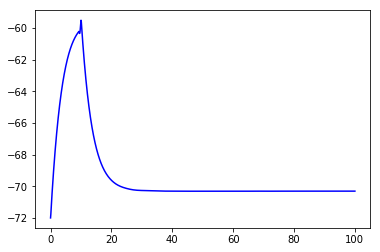

In [111]:
# create timescale. t_interval is the time interval in which to calculate the solution.
# t_points are the points at which the solution is stored.
t_interval = (0.0, 100.0)
numpoints = 1000
t_points = np.linspace(t_interval[0], t_interval[1], numpoints)

# solve coupled ODEs with scipy's solver
soln = sp_int.solve_ivp(f, t_interval, y_0, 'RK45', t_points)

# plot & show solution
plt.plot(soln.t, soln.y[0, :], 'b')
plt.show()
